## Building a Spam Filter with Naive Bayes

In this project, we're going to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. Our goal is to write a program that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

To train the algorithm, we'll use a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from th[e The UCI Machine Learning Reposito](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)ry. The data collection process is described in more details o[n this pa](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition)ge, where you can also find some of the papers authored by Tiago A. Almeida and José María Gómez Hidalgo.

## Exploring the Dataset
We'll now start by reading in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sms_spam = pd.read_csv('../Datasets/SMSSpamCollection', sep='\t', header=None, names=['label', 'sms'])
print(sms_spam.shape) 

(5572, 2)


In [3]:
sms_spam.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Below, we see that about 87% of the messages are ham, and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham.

In [4]:
sms_spam['label'].value_counts(normalize=True) * 100

label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

## Training and Test Set

We're now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.

In [5]:
import math
indices = math.ceil(0.8 * sms_spam.shape[0])

In [6]:
sms_spam = sms_spam.sample(frac=1, random_state=1).reset_index(drop=True)

In [7]:
training_set = sms_spam[:indices]
test_set = sms_spam[indices:]
training_set.shape, test_set.shape

((4458, 2), (1114, 2))

In [8]:
test_set['label'].value_counts()

label
ham     967
spam    147
Name: count, dtype: int64

In [9]:
training_set['label'].value_counts()

label
ham     3858
spam     600
Name: count, dtype: int64

In [10]:

# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [11]:
training_set['label'].value_counts(normalize=True) * 100

label
ham     86.675639
spam    13.324361
Name: proportion, dtype: float64

In [12]:
test_set['label'].value_counts(normalize=True) * 100

label
ham     86.265709
spam    13.734291
Name: proportion, dtype: float64

We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [13]:
training_set['label'].value_counts(normalize=True)

label
ham     0.866756
spam    0.133244
Name: proportion, dtype: float64

In [14]:
test_set['label'].value_counts(normalize=True)

label
ham     0.862657
spam    0.137343
Name: proportion, dtype: float64


The results look good! We'll now move on to cleaning the dataset.

## Data Cleaning

In [36]:
training_set.iloc[7]

label                                                  ham
sms      BABE !!! I miiiiiiissssssssss you ! I need you...
Name: 7, dtype: object

In [27]:
pattern = r"(\W+)"

In [40]:
training_set.iloc[7].str.extract(pattern).value_counts().iloc[:8]

0   
!!!     1
Name: count, dtype: int64

In [52]:
training_set.iloc[7].str.replace(pattern, ' ', regex=True)

label                                                  ham
sms      BABE I miiiiiiissssssssss you I need you I cra...
Name: 7, dtype: object

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

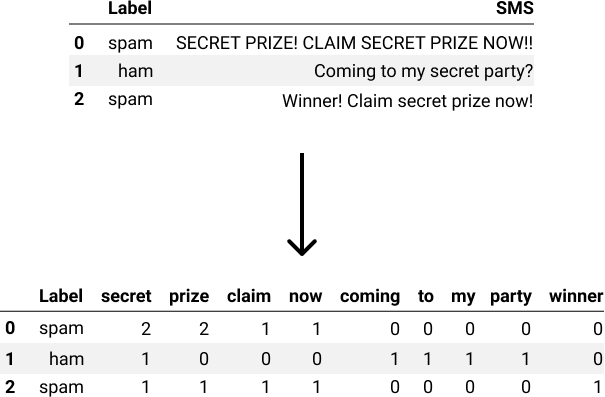

## Letter Case and Punctuation
We'll begin with removing all the punctuation and bringing every letter to lower case.

In [55]:
# Before cleaning
training_set.head()

,label,sms
0,ham,Good night my dear.. Sleepwell&amp;Take care
1,ham,Sen told that he is going to join his uncle fi...
2,ham,Thank you baby! I cant wait to taste the real ...
3,ham,When can ü come out?
4,ham,No. Thank you. You've been wonderful


In [54]:
training_set['sms'].str.lower().str.replace(pattern, ' ', regex=True)

0              good night my dear sleepwell amp take care
1       sen told that he is going to join his uncle fi...
2       thank you baby i cant wait to taste the real t...
3                                    when can ü come out 
4                      no thank you you ve been wonderful
                              ...                        
4453    sun cant come to earth but send luv as rays cl...
4454    well boy am i glad g wasted all night at apple...
4455                             ya going for restaurant 
4456    anyway seriously hit me up when you re back be...
4457    noooooooo please last thing i need is stress f...
Name: sms, Length: 4458, dtype: object

In [57]:
# After cleaning
training_set['sms'] = training_set['sms'].str.replace(pattern, ' ', regex=True)
training_set['sms'] = training_set['sms'].str.lower()
training_set.head()

,label,sms
0,ham,good night my dear sleepwell amp take care
1,ham,sen told that he is going to join his uncle fi...
2,ham,thank you baby i cant wait to taste the real t...
3,ham,when can ü come out
4,ham,no thank you you ve been wonderful


In [61]:
vocab = []
for message in training_set['sms'].tolist():
    for word in message.split():
        vocab.append(word)

len(vocab)

72282

In [62]:
len(set(vocab))

7712